In [1]:
import pandas as pd
import numpy as np


In [2]:
insurance_df = pd.read_csv('insurance.csv'); 
insurance_df['sex'] = insurance_df.sex.map({'female': 0,'male': 1})
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520


In [3]:
heart_df = pd.read_csv('heart.csv'); 
heart_df =heart_df.rename(columns = {'target' : 'heart_disease'})
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df_all =pd.merge(insurance_df,heart_df,on=['age','sex'],how='inner')
df_all.drop_duplicates()
df_all.head()

,age,sex,bmi,children,smoker,region,charges,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,46,0,33.44,1,no,southeast,8240.5896,2,142,177,0,0,160,1,1.4,0,0,2,1
1,46,0,33.44,1,no,southeast,8240.5896,1,105,204,0,1,172,0,0.0,2,0,2,1
2,46,0,33.44,1,no,southeast,8240.5896,0,138,243,0,0,152,1,0.0,1,0,2,1
3,46,0,27.74,0,no,northwest,8026.6666,2,142,177,0,0,160,1,1.4,0,0,2,1
4,46,0,27.74,0,no,northwest,8026.6666,1,105,204,0,1,172,0,0.0,2,0,2,1


In [5]:
from scipy import stats
outliers= df_all[['trestbps', 'chol', 'thalach', 'oldpeak']]  
zscore = np.abs(stats.zscore(outliers))

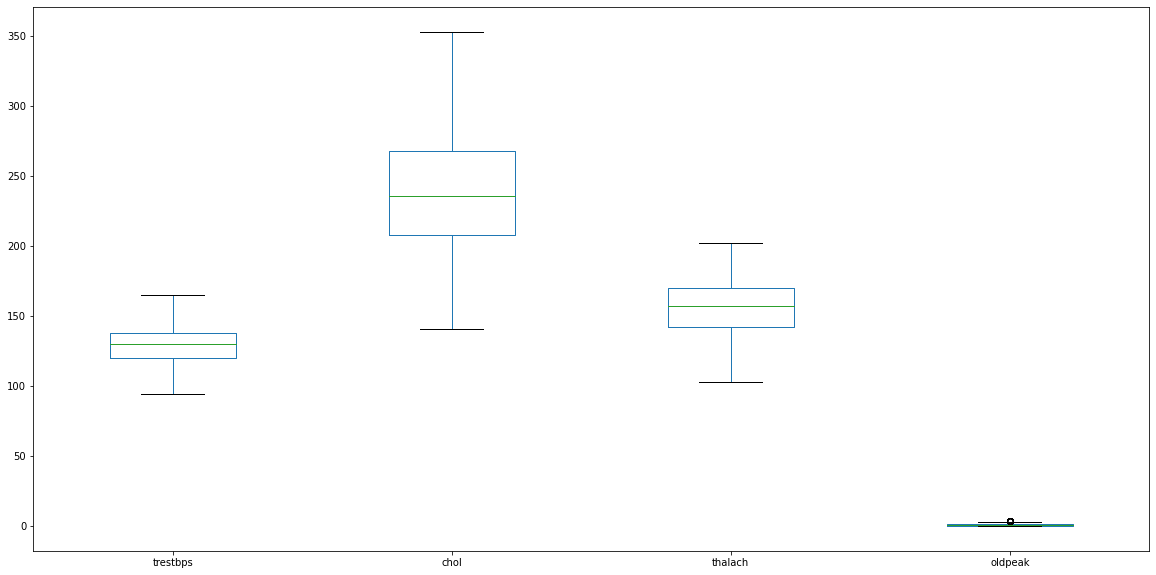

In [6]:
threshold =2.3
df_all[(zscore < threshold).all(axis=1)][['trestbps', 'chol', 'thalach', 'oldpeak']].plot(kind ='box', figsize =(20,10))

In [7]:
df_all =df_all[(zscore < threshold).all(axis=1)]

In [8]:
numerical_continous = [var for var in df_all.columns if df_all[var].dtype!='O']
numerical_continous.remove('charges');numerical_continous.remove('heart_disease'); #removing the targets
print(numerical_continous)

['age', 'sex', 'bmi', 'children', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [9]:
numerical_discrete = []

for var in df_all:
    if df_all[var].nunique()<20 and df_all[var].dtype!='O':
        numerical_discrete.append(var)
        
numerical_discrete.remove('heart_disease')     #removing the target   
print(numerical_discrete)

['sex', 'children', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [10]:
categorical = [var for var in df_all.columns if df_all[var].dtype=='O']
print(categorical)

['smoker', 'region']


In [11]:
#cateorical columns
from scipy.stats import chi2_contingency

chi2_check = []
for i in categorical + numerical_discrete:
    if chi2_contingency(pd.crosstab(df_all['heart_disease'], df_all[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [categorical + numerical_discrete, chi2_check]).T 
res.columns = ['Column', 'Hypothesis']
print(res)

      Column                      Hypothesis
0     smoker  Fail to Reject Null Hypothesis
1     region  Fail to Reject Null Hypothesis
2        sex          Reject Null Hypothesis
3   children          Reject Null Hypothesis
4         cp          Reject Null Hypothesis
5        fbs  Fail to Reject Null Hypothesis
6    restecg          Reject Null Hypothesis
7      exang          Reject Null Hypothesis
8      slope          Reject Null Hypothesis
9         ca          Reject Null Hypothesis
10      thal          Reject Null Hypothesis


In [12]:
categorical_selected =res[res.Hypothesis == 'Fail to Reject Null Hypothesis'].Column.tolist()
df_all =df_all.drop(columns =categorical_selected)
df_all.head()

,age,sex,bmi,children,charges,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,46,0,33.44,1,8240.5896,2,142,177,0,160,1,1.4,0,0,2,1
1,46,0,33.44,1,8240.5896,1,105,204,1,172,0,0.0,2,0,2,1
2,46,0,33.44,1,8240.5896,0,138,243,0,152,1,0.0,1,0,2,1
3,46,0,27.74,0,8026.6666,2,142,177,0,160,1,1.4,0,0,2,1
4,46,0,27.74,0,8026.6666,1,105,204,1,172,0,0.0,2,0,2,1


### 1. Separate df_all to two dataframes df_regression and df_classificaion each having all the features but only the respective target column

In [13]:
df_regression =df_all.drop('heart_disease',axis=1)
df_regression.head()

,age,sex,bmi,children,charges,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal
0,46,0,33.44,1,8240.5896,2,142,177,0,160,1,1.4,0,0,2
1,46,0,33.44,1,8240.5896,1,105,204,1,172,0,0.0,2,0,2
2,46,0,33.44,1,8240.5896,0,138,243,0,152,1,0.0,1,0,2
3,46,0,27.74,0,8026.6666,2,142,177,0,160,1,1.4,0,0,2
4,46,0,27.74,0,8026.6666,1,105,204,1,172,0,0.0,2,0,2


In [14]:
df_classificaion =df_all.drop('charges',axis=1)
df_classificaion.head()

,age,sex,bmi,children,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,46,0,33.44,1,2,142,177,0,160,1,1.4,0,0,2,1
1,46,0,33.44,1,1,105,204,1,172,0,0.0,2,0,2,1
2,46,0,33.44,1,0,138,243,0,152,1,0.0,1,0,2,1
3,46,0,27.74,0,2,142,177,0,160,1,1.4,0,0,2,1
4,46,0,27.74,0,1,105,204,1,172,0,0.0,2,0,2,1


### 2. Model the data effectively for the ML.

In [15]:
#regression data
X =df_regression.drop(columns =['charges'])
y =df_regression['charges']


#classification data
X1 =df_classificaion.drop(columns =['heart_disease'])
y1 =df_classificaion['heart_disease']

In [16]:
#splitting the data into train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size =0.2)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1,test_size =0.2)

### 3. Identify the best algorithm for each use case from the list of possible ML methods under consideration for each task. Your decision should be based on training time, prediction time, training and testing score.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
import time

In [18]:
#regression model
regression_models =[LinearRegression(),DecisionTreeRegressor(),BaggingRegressor(),AdaBoostRegressor()]

np.random.seed(42)

training_time =[]
prediction_time =[]
training_score =[]
testing_score =[]

for var in regression_models:
    model =var
    #training
    start =time.time()
    model.fit(X_train, y_train)
    stop =time.time()
    training_time.append(stop - start)
    #predicting
    start1 =time.time()
    pred =model.predict(X_test)
    stop1 =time.time()
    prediction_time.append(stop1 - start1)
    
    #score
    training_score.append(model.score(X_train, y_train))
    testing_score.append(model.score(X_test,y_test))

print('training_time   =', training_time)    
print('prediction_time =', prediction_time)
print('training_score  =', training_score)
print('testing_score   =', testing_score)


training_time   = [0.8689148426055908, 0.05100440979003906, 0.45304393768310547, 0.29202914237976074]
prediction_time = [0.006997346878051758, 0.011006832122802734, 0.01900315284729004, 0.016977310180664062]
training_score  = [0.08620149819646195, 1.0, 0.9318906819543059, 0.034440573742574476]
testing_score   = [0.07475222907204448, 0.5784204839194034, 0.6072434018672817, 0.003695261395615268]


#### the best regressor is the BaggingRegressor. This is because it has the highest testingand its training score is high to.

In [19]:
#classification 
from sklearn.linear_model import LogisticRegression  #Logistic Regression 
from sklearn.svm import SVC   #Support vector machine
from sklearn.neighbors import KNeighborsClassifier  #K nearest Neighbours 
from sklearn.ensemble import RandomForestClassifier  #Random Forest 
import time

In [20]:
#classification model
classification_models =[LogisticRegression(),SVC(),KNeighborsClassifier(),RandomForestClassifier()]

np.random.seed(42)

training_time =[]
prediction_time =[]
training_score =[]
testing_score =[]

for var in classification_models:
    model =var
    #training
    start =time.time()
    model.fit(X1_train, y1_train)
    stop =time.time()
    training_time.append(stop - start)
    #predicting
    start1 =time.time()
    pred =model.predict(X1_test)
    stop1 =time.time()
    prediction_time.append(stop1 - start1)
    
    #score
    training_score.append(model.score(X1_train, y1_train))
    testing_score.append(model.score(X1_test, y1_test))
    

print('training_time   =', training_time)    
print('prediction_time =', prediction_time)
print('training_score  =', training_score)
print('testing_score   =', testing_score)

C:\Users\Morris\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training_time   = [0.4813039302825928, 0.7615318298339844, 0.13500261306762695, 1.2570736408233643]
prediction_time = [0.008024930953979492, 0.11600065231323242, 0.14901018142700195, 0.10300302505493164]
training_score  = [0.864344262295082, 0.7381147540983607, 0.9979508196721312, 1.0]
testing_score   = [0.839607201309329, 0.7659574468085106, 0.9934533551554828, 1.0]


#### the best classifier model is the RandomForestClassifier. though it has the longest training time, the choice is due to the accuracy recorded.

### 4. When the best model for each task has been identified, use GridSearch on each of the models to identify the best hyper parameters.

In [21]:
#best models BaggingRegressor and RandomForestClassifier
#1) for regression model
# GridSearchCV...
np.random.seed(42)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Define the regression parameters to search over
param_grid = {'n_estimators': [i for i in range(10, 100, 10)]
             }
# Define the classification parameters to search over
param_grid_1 = {'n_estimators': [i for i in range(10, 100, 10)]  
             }

# Setup the grid search
grid = GridSearchCV(BaggingRegressor(),
                    param_grid,
                   cv=5)

grid_1 = GridSearchCV(RandomForestClassifier(),
                    param_grid_1,
                   cv=5)

# Fit the grid search to the data
grid.fit(X, y)
grid_1.fit(X1, y1)

# Find the best parameters
print('regression best parameters ', grid.best_params_)
print('classification best parameters ', grid_1.best_params_)

regression best parameters  {'n_estimators': 80}
classification best parameters  {'n_estimators': 90}


### 5. Set up an new instance of both the regression and classification model with the identified parameters, train the models and report both the training and testing cross validation mean score and standard deviation over 5 cross folds.

In [22]:
grid.best_estimator_

BaggingRegressor(n_estimators=80)

In [23]:
grid_1.best_estimator_

RandomForestClassifier(n_estimators=90)

In [24]:
#regression
np.random.seed(42)
reg_model =grid.best_estimator_
reg_model.fit(X_train, y_train)

print(f"regression Cross-validation train score: {np.abs(np.mean(cross_val_score(reg_model, X_train, y_train, cv=5))) * 100}%")
print(f"regression Cross-validation test score: {np.abs(np.mean(cross_val_score(reg_model, X_test, y_test, cv=5))) * 100}%")
print(f"regression Cross-validation train standard deviation: {np.std(cross_val_score(reg_model, X_train, y_train, cv=5))}")
print(f"regression Cross-validation test standard deviation: {np.std(cross_val_score(reg_model, X_test, y_test, cv=5))}")
print()
#classifiction
np.random.seed(42)
class_model =grid_1.best_estimator_
class_model.fit(X1_train, y1_train)

print(f"classification Cross-validation train score: {np.abs(np.mean(cross_val_score(class_model, X1_train, y1_train, cv=5))) * 100}%")
print(f"classification Cross-validation test score: {np.abs(np.mean(cross_val_score(class_model, X1_test, y1_test, cv=5))) * 100}%")
print(f"classification Cross-validation train standard deviation: {np.std(cross_val_score(class_model, X1_train, y1_train, cv=5))}")
print(f"classification Cross-validation test standard deviation: {np.std(cross_val_score(class_model, X1_test, y1_test, cv=5))}")


regression Cross-validation train score: 57.537031752247124%
regression Cross-validation test score: 3.3235513834750896%
regression Cross-validation train standard deviation: 0.09425686101822212
regression Cross-validation test standard deviation: 0.13995412676432203

classification Cross-validation train score: 100.0%
classification Cross-validation test score: 97.0558443289351%
classification Cross-validation train standard deviation: 0.0
classification Cross-validation test standard deviation: 0.009456459367586859


### 6. Using the following metrics, report the testing accuracy of each of the models using the following: a. Classification:(i. Classification report. ii. Heatmap confusion matrix. ) b. Regression:(i. Mean Absolute Error ii. Mean Squared Error iii. R2-Score)

#### classification

In [25]:
#classification
#i. Classification report
from sklearn.metrics import classification_report
np.random.seed(42)
class_model =grid_1.best_estimator_
class_model.fit(X1_train, y1_train)
preds =class_model.predict(X1_test)

print(classification_report(y1_test, preds))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       1.00      1.00      1.00       362

    accuracy                           1.00       611
   macro avg       1.00      1.00      1.00       611
weighted avg       1.00      1.00      1.00       611



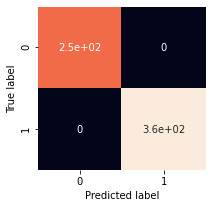

In [26]:
#ii Heatmap confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
def plot_conf_mat(conf_mat):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(conf_mat,
                     annot=True, # Annotate the boxes 
                     cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label');

conf_mat=confusion_matrix(y1_test, preds)

plot_conf_mat(conf_mat)

#### regression

In [27]:
#regression
np.random.seed(42)
reg_model =grid.best_estimator_
reg_model.fit(X_train, y_train)
reg_preds =reg_model.predict(X_test)

#i. Mean Absolute Error
from sklearn.metrics import mean_absolute_error
Mean_Absolute_Error = mean_absolute_error(y_test, reg_preds)
Mean_Absolute_Error

4435.808073559124

In [28]:
#ii. Mean Squared Error
from sklearn.metrics import mean_squared_error

mean_squared_error = mean_squared_error(y_test, reg_preds)
mean_squared_error

51149494.48331862

In [29]:
#iii. R2-Score
# Calculate the models R^2 score
reg_model.score(X_test, y_test)


0.6489814135756979

In [30]:
from sklearn.metrics import r2_score

r2_score(y_test, reg_preds)


0.6489814135756979

### 7. Save both models as a pickle file bearing the respective names: a. Regression – ‘regression_model’ b. Classification – ‘classification_model’

In [31]:
import pickle

# Save an existing model to file
pickle.dump(reg_model, open("regression_model.pkl", "wb"))
pickle.dump(class_model, open("classification_model.pkl", "wb"))
